In [1]:
# 데이터 전처리
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import random
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re

# lstm_model
from keras.layers import *
from keras import backend as K
from keras import optimizers
import keras
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, BatchNormalization, Dropout
from keras.models import Sequential
from keras import Input, Model

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# Word2Vec model
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors

# 하이퍼 파라미터, CV(Cross Validation)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from keras.callbacks import *
from keras.utils.np_utils import to_categorical


In [21]:
dataset = pd.read_csv('./fds/data/dataset/dataset.csv',names=['text','fishing'])

In [24]:
dataset.head()

,text,fishing
0,"네, 지금 방송 중인 상품 사려고요.네, 무엇을 도와드릴까요?네 정보 확인 후 주문...",0
1,아 지금 방송하고 있는 거.예 아 그런데 제가 만약 생각 좀 해 보고 카드 결제로 ...,0
2,지금 방송하는 상품 주문되나요?제가 ㅇㅇ쇼핑에 등록되어 있지 않나요?휴대폰번호로 등...,0
3,근무하시는 물어보세요 알아보니까 경룡 끝났는데 왜 저희는 그거를 다 소화를 할 수...,1
4,네. 안녕하세요. 모바일로 주문하려고 해서 주문서를 쓰는데요.사만 팔천원으로 나오는...,0


In [51]:
fishing = len(dataset.loc[dataset['fishing']==0])
non_fishing = len(dataset.loc[dataset['fishing']==1])
num_data = len(dataset['fishing'])

print('정상 비율 {}% {}/{}'.format(round(non_fishing/num_data * 100,3),non_fishing,num_data))
print('보이스피싱 비율 {}% {}/{}'.format(round(fishing/num_data * 100,3),fishing,num_data))


정상 비율 7.759% 464/5980
보이스피싱 비율 92.241% 5516/5980


<AxesSubplot:xlabel='fishing', ylabel='count'>

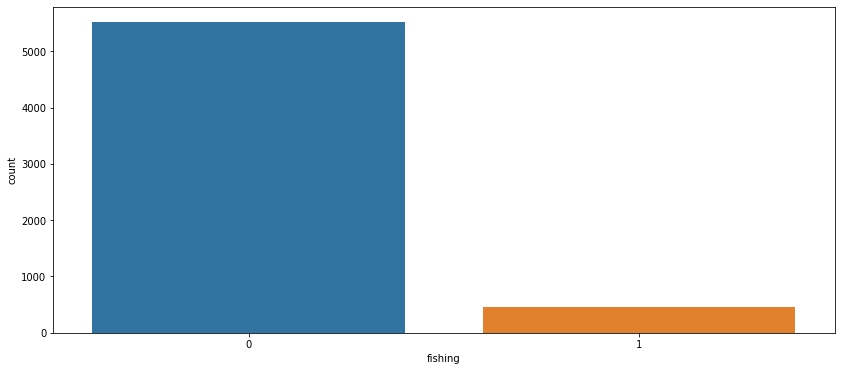

In [52]:
plt.figure(figsize=(14,6))
sns.countplot(data=dataset,x='fishing')

In [53]:
dataset['length'] = dataset['text'].apply(lambda x: len(x))
fishing = dataset.loc[dataset['fishing']==1]
non_fishing = dataset.loc[dataset['fishing']==0]

dataset.head()

,text,fishing,length
0,청바지 주문되나요?ㅇㅇ쇼핑 ㅇㅇㅇ 입니다. 무엇을 도와드릴까요?네 고객님 정보 확인...,0,566
1,네 접이식 옷걸이 여쭤보려구요. 아 예 현금으로 무통장 입금 했는데 카드로 바꾸고 ...,0,1117
2,"아 제가 지금 이동 중이어서, 방송 중인 상품을 구입하려고 전화드렸습니다.네, 고객...",0,705
3,있습니다 연체가 없으실경우 원리금균등분할상환 원금만기일시상환 방식중 3일에 변경 ...,1,680
4,방송에 나오는 신발 주문하려구요.언제까지 입금해야 되나요?그럼 언제 배송되나요? 지...,0,546


d:\programming\github\speech-recognition\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length'>

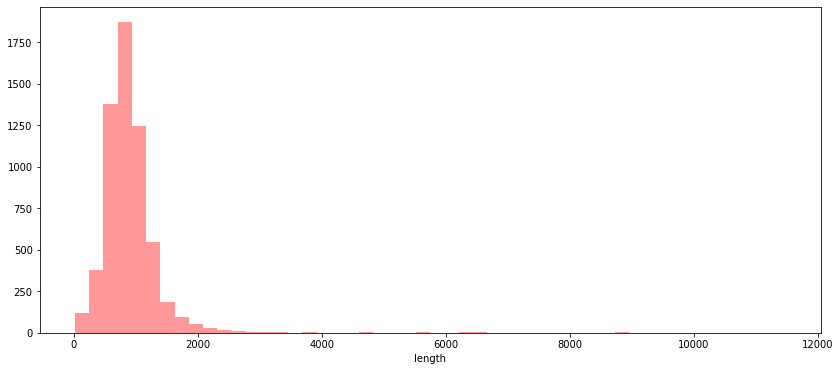

In [54]:
plt.figure(figsize=(14,6))
sns.distplot(dataset['length'],kde=False, bins=50, color='r')

d:\programming\github\speech-recognition\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


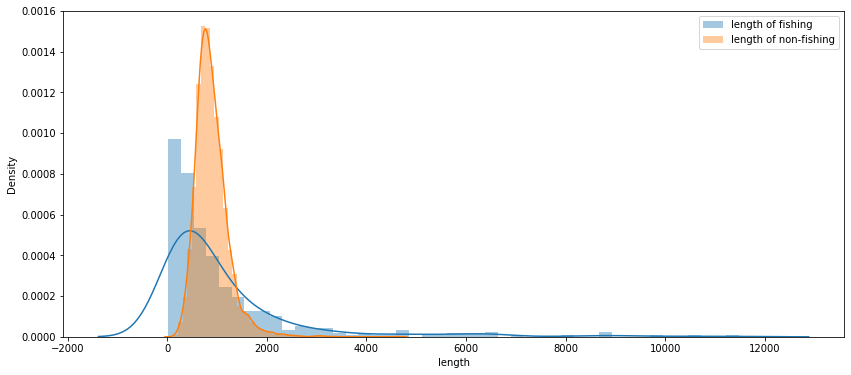

In [8]:
plt.figure(figsize=(14,6))
sns.distplot(fishing['length'], label='length of fishing')
sns.distplot(non_fishing['length'], label='length of non-fishing')
plt.legend()

In [55]:
dataset['length'].describe()

count     5980.000000
mean       911.911538
std        549.955743
min         20.000000
25%        661.750000
50%        832.000000
75%       1057.000000
max      11475.000000
Name: length, dtype: float64

In [56]:
print(np.percentile(dataset['length'],80))
print('전체 평균 길이 : {}'.format(np.mean(dataset['length'])))
print('피싱 평균 길이 : {}'.format(np.mean(fishing['length'])))
print('정상 평균 길이 : {}'.format(np.mean(non_fishing['length'])))


1116.0
전체 평균 길이 : 911.9115384615385
피싱 평균 길이 : 1131.217672413793
정상 평균 길이 : 893.4637418419144


In [57]:
iqr1 = dataset['length'].describe()['25%']
iqr3 = dataset['length'].describe()['75%']

ceil_outlier = iqr3 + 1.5 * (iqr3 - iqr1)
bot_outlier = iqr1 - 1.5 * (iqr3-iqr1)

outlier = (np.percentile(dataset['length'],5), np.percentile(dataset['length'],95))

(ceil_outlier, bot_outlier), outlier

((1649.875, 68.875), (394.95, 1568.1000000000004))

In [61]:
print(len(dataset))

5980


In [92]:
len(dataset)

5980

## 데이터 전처리

### 불용어 제거 및 토크나이징

In [3]:
from konlpy.tag import Okt
okt = Okt()

In [5]:
# 구두점과 특수문자 제거
dataset['text(clean)'] = dataset['text'].str.replace('[\\WX]',' ')

# 문장에서 뜻이 될 만한 품사 태그
p = ['Noun','Verb','Adjective','Adverb']
# 불용어
stopwords = ['ㄱ','ㄴ,','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ','ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','가','나','다','라','마','바','사','아','자','차','카','타','파','하','가가','듀']

C:\Users\PC\AppData\Local\Temp\ipykernel_2056\865786722.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['text(clean)'] = dataset['text'].str.replace('[\\WX]',' ')


In [6]:
# 문장 토큰화
def tokenizer(data, pos=p, stopword=stopwords):
    tokened = okt.pos(data)

    return [word for word, tag in tokened if tag in pos and word not in stopword]

In [7]:
train = dataset[:4784]
test = dataset[4784:]

In [8]:
train['tokenized'] = train['text(clean)'].apply(tokenizer)

print(train.shape)
train.head(2)

(4784, 4)


C:\Users\PC\AppData\Local\Temp\ipykernel_2056\3864964366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tokenized'] = train['text(clean)'].apply(tokenizer)


,text,fishing,text(clean),tokenized
0,네 지금 카드로 결제를 했는데 오류가 생겼다고 해서요. 확인 좀 해주세요.네 반갑습...,0,네 지금 카드로 결제를 했는데 오류가 생겼다고 해서요 확인 좀 해주세요 네 반갑습...,"[네, 지금, 카드, 결제, 했는데, 오류, 생겼다고, 해서요, 확인, 좀, 해주세..."
1,예 주문할려고 그러거든요. 네 이게 전화로 해서 적립금 있나요? 국민 카드 청구 할...,0,예 주문할려고 그러거든요 네 이게 전화로 해서 적립금 있나요 국민 카드 청구 할...,"[예, 주문, 할려고, 그러거든요, 네, 이, 전화, 해서, 적립금, 있나요, 국민..."


In [9]:
test['tokenized'] = test['text(clean)'].apply(tokenizer)

print(test.shape)
test.head(2)

(1196, 4)


C:\Users\PC\AppData\Local\Temp\ipykernel_2056\1142788433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tokenized'] = test['text(clean)'].apply(tokenizer)


,text,fishing,text(clean),tokenized
4784,"네, 가방 신청을 하고싶어서요.네, 이거 소가죽 상품이 맞나요?네, 주문을 도와드릴...",0,네 가방 신청을 하고싶어서요 네 이거 소가죽 상품이 맞나요 네 주문을 도와드릴...,"[네, 가방, 신청, 하고싶어서요, 네, 거, 가죽, 상품, 맞나요, 네, 주문, ..."
4785,주문을 했는데 좀 확인 좀 해볼게요. ㅇㅇㅇ이요.주문은 잘 됐나요?그리고 회원 가입...,0,주문을 했는데 좀 확인 좀 해볼게요 ㅇㅇㅇ이요 주문은 잘 됐나요 그리고 회원 가입...,"[주문, 했는데, 좀, 확인, 좀, 해볼게요, 이요, 주문, 잘, 됐나요, 회원, ..."


In [10]:
# train set test-val 분리
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.3, random_state=42)
train.shape, test.shape

((3348, 4), (1196, 4))

## 워드 임베딩(Word Embedding)

### 워드 임베딩 - Word2Vec

In [11]:
bigrams = Phrases(sentences=train.tokenized)
trigrams = Phrases(sentences=bigrams[train.tokenized])

In [12]:
N_SPLITS = 5
EMBEDDING_SIZE = 256

In [13]:
tri_model = Word2Vec(sentences=trigrams[bigrams[train.tokenized]],vector_size=EMBEDDING_SIZE,window=10,min_count=10,workers=4,sg=1)
tri_model.wv.save_word2vec_format('w2v_model')
loaded_model = KeyedVectors.load_word2vec_format('w2v_model')

In [14]:
max_word = len(tri_model.wv.key_to_index)
print('vocabulary size : ',max_word)

vocabulary size :  4826


In [15]:
def vectorize_data(data,vocab: dict) -> list:
    print('Vectorize sentences...',end='\r')
    keys=list(vocab.keys())
    filter_unknown = lambda word : vocab.get(word,None) is not None
    encode = lambda review : list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorie sentence.. (done)')
    return vectorized

X_data = train.tokenized
input_length = max(list(map(len,X_data)))
X = pad_sequences(
    sequences = vectorize_data(X_data, vocab=tri_model.wv.key_to_index),
    maxlen = input_length,
    padding = 'post'
)
y = train['fishing'].values

Vectorie sentence.. (done)


In [16]:
X_test = pad_sequences(sequences=vectorize_data(test.tokenized, vocab=tri_model.wv.key_to_index),
maxlen = input_length, padding = 'post')

Vectorie sentence.. (done)


In [17]:
X_val = pad_sequences(sequences=vectorize_data(val.tokenized, vocab=tri_model.wv.key_to_index),maxlen=input_length,padding='post')

y_val = val['fishing'].values

Vectorie sentence.. (done)


In [18]:
X.shape, y.shape, X_val.shape, y_val.shape

((3348, 2385), (3348,), (1436, 2385), (1436,))

## 어텐션(Attention)을 적용한 양방향 LSTM 모델

In [89]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint = None, b_constraint = None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = keras.initializers.he_normal(seed=42)
        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention,self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.init,
                                    name='{}_W'.format(self.name),
                                    regularizer=self.W_regularizer,
                                    constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),initializer='zero',name='{}_b'.format(self.name),regularizer=self.b_regularizer,constraint=self.b_constraint)
        else:
            self.b = None
        
        self.built = True
    
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x,(-1,features_dim)),K.reshape(self.W, (features_dim,1))), (-1,step_dim))

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(),K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

### NN LSTM Model

In [91]:
def build_model(embedding_matrix:np.ndarray, input_length: int):
    model = keras.Sequential()

    model.add(Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],input_length=input_length,weights=[embedding_matrix],trainable=False))
    # 양방향 LSTM 층
    model.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Attention(input_length))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2,activation='Softmax'))
    adam = optimizers.Adam(lr=0.001, amsgrad=True)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

model_lstm = build_model(embedding_matrix=tri_model.wv.vectors,input_length=X.shape[1])
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 3215, 256)         1241600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 3215, 256)        394240    
 nal)                                                            
                                                                 
 attention_4 (Attention)     (None, 256)               3471      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [94]:
batch_size = 1024
trained = model_lstm.fit(X,y, epochs=30, batch_size=batch_size, validation_data=(X_val,y_val),callbacks=[early_stopping_callback])

Epoch 1/30


: 

: 